In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from torch.amp import autocast, GradScaler
from efficientnet_pytorch import EfficientNet

In [15]:
# Check for GPU availability
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return 0
print(torch.cuda.get_device_name(0))  # Should print "NVIDIA GeForce RTX 3050 Laptop GPU"

# Define constants
IMG_HEIGHT = 224  # Common input size for all models
IMG_WIDTH = 224
BATCH_SIZE = 4    # Reduced for multi-model memory constraints
EPOCHS = 50
NUM_CLASSES = 4   # Matches your 4 classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [16]:
# Define individual models
class BaseModel(nn.Module):
    def __init__(self, arch, pretrained=True, num_classes=NUM_CLASSES):
        super(BaseModel, self).__init__()
        if arch == 'efficientnet_b0':
            self.model = EfficientNet.from_pretrained('efficientnet-b0')
            num_features = self.model._fc.in_features
            self.model._fc = nn.Linear(num_features, num_classes)
        elif arch == 'resnet18':
            self.model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, num_classes)
        elif arch == 'mobilenet_v3':
            self.model = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
            num_features = self.model.classifier[0].in_features
            self.model.classifier = nn.Sequential(
                nn.Linear(num_features, num_classes)
            )
        else:
            raise ValueError(f"Unsupported architecture: {arch}")
        
        # Freeze base model parameters
        for param in self.model.parameters():
            param.requires_grad = False
        # Unfreeze the final layer for training
        for param in self.model.fc.parameters() if arch == 'resnet18' else self.model._fc.parameters() if arch == 'efficientnet_b0' else self.model.classifier[0].parameters():
            param.requires_grad = True
    
    def forward(self, x):
        return self.model(x)

In [17]:
# Ensemble Model
class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList([
            BaseModel('efficientnet_b0'),
            BaseModel('resnet18'),
            BaseModel('mobilenet_v3')
        ])
        self.num_classes = num_classes
    
    def forward(self, x):
        outputs = []
        for model in self.models:
            with autocast('cuda'):
                output = model(x)
                outputs.append(torch.softmax(output, dim=1))
        # Average the softmax probabilities
        avg_output = torch.stack(outputs).mean(dim=0)
        return avg_output

In [18]:
# Data preprocessing and augmentation
def create_data_loaders(train_dir, val_dir):
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, val_loader, train_dataset.classes

In [19]:
# Training function with mixed precision
def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler('cuda')
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            
            with autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                with autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{EPOCHS}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history

In [20]:
# Plotting function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history['train_acc'], label='Training Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    
    ax2.plot(history['train_loss'], label='Training Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [21]:
# Evaluation function
def evaluate_model(model, val_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with autocast('cuda'):
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [22]:
# Test a single image
def test_single_image(model_path, image_path, class_names):
    model = EnsembleModel(num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        with autocast('cuda'):
            output = model(image)
        probabilities = output[0]  # Take the first (and only) output
        predicted_class = torch.argmax(probabilities).item()

    print("\nPrediction Results:")
    print(f"Predicted Class: {class_names[predicted_class]}")
    print("Probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{class_names[i]}: {prob:.4f}")

In [23]:
# Test multiple images
def test_multiple_images(model_path, test_dir, class_names):
    model = EnsembleModel(num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()

    test_loader, _, _ = create_data_loaders(test_dir, test_dir)
    evaluate_model(model, test_loader, class_names)


Loaded pretrained weights for efficientnet-b0
Using device: cuda
Epoch 1/50:
Train Loss: 1.0418, Train Acc: 72.80%
Val Loss: 0.9998, Val Acc: 76.36%
Epoch 2/50:
Train Loss: 0.9843, Train Acc: 78.30%
Val Loss: 0.9816, Val Acc: 78.60%
Epoch 3/50:
Train Loss: 0.9673, Train Acc: 79.84%
Val Loss: 0.9572, Val Acc: 80.06%
Epoch 4/50:
Train Loss: 0.9564, Train Acc: 80.98%
Val Loss: 0.9527, Val Acc: 80.50%
Epoch 5/50:
Train Loss: 0.9523, Train Acc: 81.27%
Val Loss: 0.9492, Val Acc: 81.18%
Epoch 6/50:
Train Loss: 0.9484, Train Acc: 81.77%
Val Loss: 0.9549, Val Acc: 79.89%
Epoch 7/50:
Train Loss: 0.9431, Train Acc: 82.34%
Val Loss: 0.9411, Val Acc: 82.13%
Epoch 8/50:
Train Loss: 0.9417, Train Acc: 82.37%
Val Loss: 0.9415, Val Acc: 82.13%
Epoch 9/50:
Train Loss: 0.9383, Train Acc: 82.77%
Val Loss: 0.9390, Val Acc: 82.80%
Epoch 10/50:
Train Loss: 0.9398, Train Acc: 82.52%
Val Loss: 0.9425, Val Acc: 82.02%
Epoch 11/50:
Train Loss: 0.9390, Train Acc: 82.30%
Val Loss: 0.9360, Val Acc: 82.86%
Epoch 12/

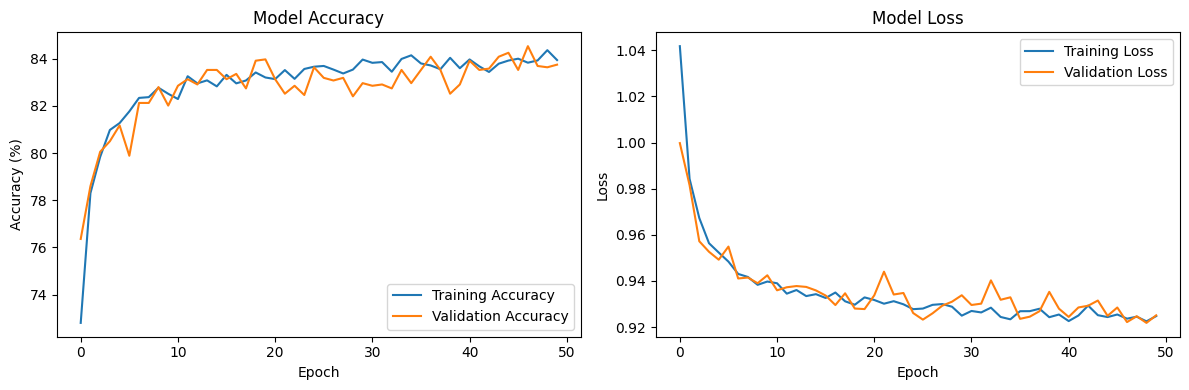


Classification Report:
              precision    recall  f1-score   support

      glioma       0.80      0.80      0.80       450
  meningioma       0.72      0.65      0.68       400
     notumor       0.92      0.98      0.95       536
   pituitary       0.87      0.88      0.87       399

    accuracy                           0.84      1785
   macro avg       0.83      0.83      0.83      1785
weighted avg       0.83      0.84      0.83      1785



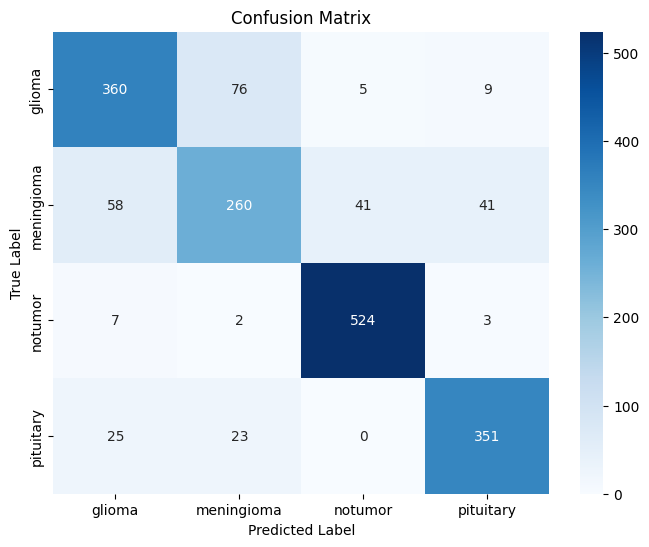

Loaded pretrained weights for efficientnet-b0


C:\Users\viraj\AppData\Local\Temp\ipykernel_32284\1611874673.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Prediction Results:
Predicted Class: notumor
Probabilities:
glioma: 0.0000
meningioma: 0.0009
notumor: 0.9971
pituitary: 0.0020


In [11]:
# Main execution
def main():
    # Define paths (update these to your actual dataset paths)
    train_dir = "C:/Users/viraj/Documents/Virajs Projects/BT DETECTION/Training"  # Replace with your actual path
    val_dir = "C:/Users/viraj/Documents/Virajs Projects/BT DETECTION/Testing"     # Replace with your actual path
    model_path = 'Ensemble_brain_tumor_classifier.pth'
    class_names = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

    # Create data loaders
    train_loader, val_loader, class_names = create_data_loaders(train_dir, val_dir)

    # Initialize and train the ensemble model
    model = EnsembleModel(num_classes=NUM_CLASSES)
    model.to(DEVICE)
    print(f"Using device: {DEVICE}")
    history = train_model(model, train_loader, val_loader)

    # Save the model
    torch.save(model.state_dict(), model_path)

    # Plot training history
    plot_training_history(history)

    # Evaluate the model
    evaluate_model(model, val_loader, class_names)

    # Testing mode
    test_mode = input("Enter 'single' to test one image or 'batch' to test multiple: ").lower()
    if test_mode == 'single':
        image_path = input("Enter the path to your test image: ")
        test_single_image(model_path, image_path, class_names)
    elif test_mode == 'batch':
        test_dir = input("Enter the path to your test directory: ")
        test_multiple_images(model_path, test_dir, class_names)
    else:
        print("Invalid mode selected. Please choose 'single' or 'batch'")

if __name__ == "__main__":
    main()

In [26]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [27]:
# 2. Define image preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

In [28]:
# 3. Load the model
def load_model(model_path, num_classes=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EnsembleModel(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model, device

In [29]:
# 4. Predict function
def predict(model, image_tensor, device, class_names):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
    
    return predicted_class.item(), probabilities[0].cpu().numpy()

In [30]:
# 5. Visualize results
def show_prediction(image_path, predicted_class, probabilities, class_names):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 5))
    
    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Predicted: {class_names[predicted_class]}')
    plt.axis('off')
    
    # Show probability distribution
    plt.subplot(1, 2, 2)
    plt.bar(class_names, probabilities)
    plt.title('Class Probabilities')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [31]:
# 6. Test single image
def test_single_image(model_path, image_path, class_names):
    # Load model
    model, device = load_model(model_path)
    
    # Preprocess image
    image_tensor = preprocess_image(image_path)
    
    # Make prediction
    predicted_class, probabilities = predict(model, image_tensor, device, class_names)
    
    # Show results
    show_prediction(image_path, predicted_class, probabilities, class_names)
    
    # Print detailed results
    print(f"\nPrediction Results:")
    print(f"Predicted Class: {class_names[predicted_class]}")
    print("Probabilities:")
    for name, prob in zip(class_names, probabilities):
        print(f"{name}: {prob:.4f}")

In [32]:
# 7. Test multiple images
def test_multiple_images(model_path, test_dir, class_names):
    model, device = load_model(model_path)
    
    correct = 0
    total = 0
    
    for class_name in class_names:
        class_dir = os.path.join(test_dir, class_name)
        if not os.path.exists(class_dir):
            continue
            
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_tensor = preprocess_image(img_path)
            
            predicted_class, probabilities = predict(model, image_tensor, device, class_names)
            
            true_class = class_names.index(class_name)
            if predicted_class == true_class:
                correct += 1
            total += 1
            
            print(f"\nImage: {img_name}")
            print(f"True Class: {class_name}")
            print(f"Predicted Class: {class_names[predicted_class]}")
            print(f"Confidence: {probabilities[predicted_class]:.4f}")
    
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"\nTest Accuracy: {accuracy:.2f}% ({correct}/{total})")

Loaded pretrained weights for efficientnet-b0


C:\Users\viraj\AppData\Local\Temp\ipykernel_34060\10975724.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


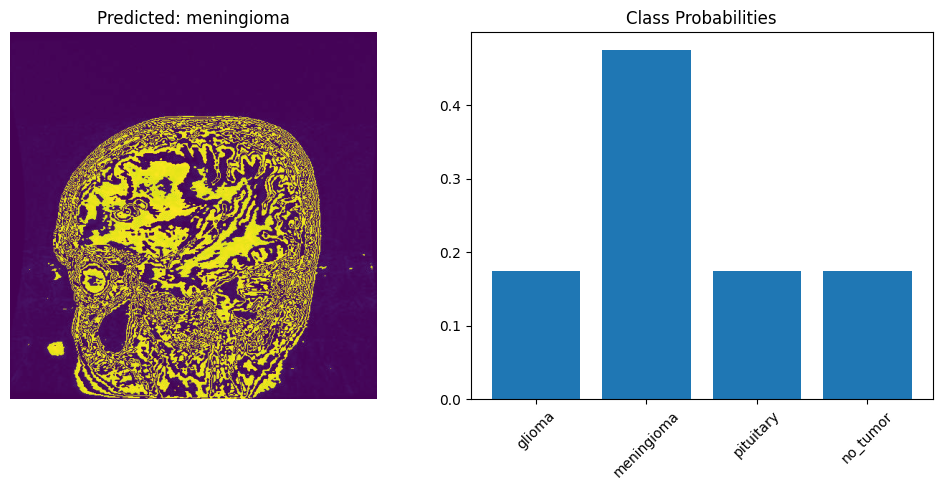


Prediction Results:
Predicted Class: meningioma
Probabilities:
glioma: 0.1749
meningioma: 0.4754
pituitary: 0.1749
no_tumor: 0.1749


In [34]:
# 8. Main execution
def main():
    # Define your parameters
    model_path = r'C:\Users\viraj\Documents\Virajs Projects\BT DETECTION\models\Ensemble_brain_tumor_classifier.pth'  # Path to your saved model
    class_names = ['glioma', 'meningioma', 'pituitary', 'no_tumor']  # Your classes
    
    # Choose testing mode
    test_mode = input("Enter 'single' to test one image or 'batch' to test multiple: ").lower()
    
    if test_mode == 'single':
        image_path = input("Enter the path to your test image: ")
        test_single_image(model_path, image_path, class_names)
    
    elif test_mode == 'batch':
        test_dir = input("Enter the path to your test directory: ")
        test_multiple_images(model_path, test_dir, class_names)
    
    else:
        print("Invalid mode selected. Please choose 'single' or 'batch'")

if __name__ == "__main__":
    main()